<a href="https://colab.research.google.com/github/naraquev/Private-AI/blob/master/research/Deep_Models_Under_the_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Models Under the GAN: Information Leakage from
Collaborative Deep Learning

https://arxiv.org/pdf/1702.07464.pdf

In [0]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy.ma as ma
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from IPython.display import clear_output
from numpy import linalg as LA
#from rdp_accountant import compute_rdp  # pylint: disable=g-import-not-at-top
#from rdp_accountant import get_privacy_spent
import warnings
warnings.filterwarnings('ignore')

In [0]:
class Generator(nn.Module):
    def __init__(self, code_len, clas):
        super(Generator, self).__init__()
        self.init_size = 28 // 4
        self.l1 = nn.Sequential(nn.Linear(100+10, 128 * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, c):
        z, c = z.view(z.size(0), -1), c.view(c.size(0), -1)
        v = torch.cat((z, c), 1)   
       
        out = self.l1(v)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [0]:
class client():
  def __init__(self, number, loader, state_dict, adversary = False, batch_size = 32, epochs=1, lr=0.01):
    self.number = number
    self.model = t_model()
    self.model.load_state_dict(state_dict)
    self.criterion = nn.NLLLoss()
    self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
    self.epochs = epochs
    self.device =  device =  torch.device("cuda:0""cuda:0" if torch.cuda.is_available() else "cpu")
    self.dataLoader = loader    
    self.adversary = adversary
    self.batch_size = batch_size
    if self.adversary:
      self.gen =  Generator(100, 4)
      self.gen = self.gen.to(device)
      self.wanted_clas = 0
      self.gen_cri = torch.nn.BCELoss()
      self.gen_cri.to(device)
      self.gen_opti = torch.optim.Adam(self.gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
           
        
  def img(self):
    self.gen.eval()
    #Creating a 10 by 10 layout for the 28x28 images
    img = np.zeros([280, 280])   
    for j in range(10):
      c = torch.zeros([10, 10]).to(device)
      c[:, 0] = 1
      z = torch.randn(10, 100).to(device)
      y_hat = self.gen(z,c).view(10, 28, 28) # (10, 28, 28)
      result = y_hat.cpu().data.numpy()                       
      img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)              
    self.gen.train()
    return img
                                  
  #
  def update(self, state_dict):
    
    self.model.load_state_dict(state_dict)
    self.model.to(self.device)
    running_loss = 0
    accuracy = 0
    for e in range(self.epochs):
        print('Epoch: ', e)        
               
        # Model in training mode, dropout is on
        self.model.train()
        accuracy=0
        running_loss = 0
        for images, labels in self.dataLoader:
          images, labels = images.to(self.device), labels.to(self.device)   
          if self.adversary:
            #Adversarial Training
            self.gen_opti.zero_grad() 
            z = torch.randn(self.batch_size, 100).to(device) 
            clas = torch.zeros(self.batch_size).long()        
            clas = clas.view(self.batch_size, 1)
            c = torch.FloatTensor(clas.size(0), 10)
            c.zero_()
            c.scatter_(1, clas, 1)
            c =c.to(device) 
            z_output = self.model(self.gen(z, c))
            D_fakes = torch.zeros(self.batch_size, 1).to(device)
            z_output = torch.exp(z_output)
            D_loss_z = self.gen_cri(z_output[:,0], D_fakes)              
            D_loss_z.backward()
            self.gen_opti.step()     
            adv_imgs = self.gen(z, c)          
            self.optimizer.zero_grad()            
            output = self.model.forward(adv_imgs) 
            A_fakes = torch.zeros((self.batch_size), dtype=torch.float64)
            A_fakes[:] = 10
            A_fakes = A_fakes.long().to(device)          
            loss = self.criterion(output, A_fakes)          
            loss.backward()
            self.optimizer.step()       
            self.gen_opti.zero_grad() 
             
          self.optimizer.zero_grad()
          output = self.model.forward(images)
          #print(output.shape)
          #print(output.shape)
          #print(labels.shape)
          loss = self.criterion(output, labels)
          #print(labels[0])
          loss.backward()
          self.optimizer.step()            
          running_loss += loss.item()     
    
    return self.model.state_dict()

In [0]:
class Server():
  def __init__(self, clients, number_clients=2):
    self.model = t_model()    
    self.testLoader = torch.utils.data.DataLoader(mnist_testset, batch_size=32)
    self.device = torch.device("cuda:0""cuda:0" if torch.cuda.is_available() else "cpu")
    self.clients = clients
    
    
  #Evaluates the accuracy of the current model with the test data.  
  def eval_acc(self):
    self.model.to(self.device)
    #print('Aqui voy!')
    running_loss = 0
    accuracy = 0
    self.model.eval()
    suma=0
    total = 0
    running_loss = 0
    for images, labels in self.testLoader:            
        images, labels = images.to(self.device), labels.to(self.device) 
        output = self.model.forward(images)             
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        total += equals.size(0)
        suma = suma + equals.sum().item()
    else:      
        print('Accuracy: ',suma/float(total))
   


  def server_exec(self):    
    i=1
    while(i<100):
      clear_output()
      print('Comunication round: ', i)
      self.eval_acc()      
      for client in self.clients:
        new_state_dict = client.update(self.model.state_dict())
        self.model.load_state_dict(new_state_dict)
      i+=1

In [0]:
class t_model(nn.Module):
    def __init__(self):
        super(t_model, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 11)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))        
        x = F.relu(self.fc3(x))
        return F.log_softmax(x)
      

In [0]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, ), (0.5,))])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
device =  torch.device("cuda:0""cuda:0" if torch.cuda.is_available() else "cpu")
num_teachers = 2
train_len = len(mnist_trainset)
test_len = len(mnist_testset)

0it [00:00, ?it/s]

9920512it [00:05, 1862664.50it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 434382.17it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 6785370.38it/s]                           
8192it [00:00, 169891.66it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
import itertools
def get_samples_noniid(num_teachers, num_clas):
  msk = []    
  for i in range(num_clas):
    mask = mnist_trainset.train_labels == i
    mask =mask.tolist()
    mask = np.array(mask)
    msk.append(mask)
  samples = []  
  for i in range(num_teachers):  
    idx = []
    for j in range(i*5, num_clas+(i*5)):      
      clas = j  
      print(i, j)
      indices =  list(range(len(mnist_trainset)))
      indices =  ma.masked_array(indices, mask=mask[clas])
      indices = indices.compressed()
      split = int(len(indices)*0.7)
      #print('Split: ',split)
      l = np.random.choice(indices, size = split)
      l = l.tolist()      
      idx = itertools.chain(idx, l)   
    #print(len(list(idx)))
    t_sampler = SubsetRandomSampler(list(idx))
    samples.append(t_sampler)    
  return samples

In [0]:
samples = get_samples_noniid(num_teachers, 5)
clear_output()

In [0]:
model = t_model()
loaderVic = torch.utils.data.DataLoader(mnist_trainset, batch_size=32, sampler=samples[0])
loaderAtc = torch.utils.data.DataLoader(mnist_trainset, batch_size=32, sampler=samples[1])
victim = client(0, loaderVic, model.state_dict(), adversary = False, batch_size = 32, epochs=5, lr=0.01)
adversary =client(1, loaderAtc, model.state_dict(), adversary = True, batch_size = 32, epochs=5, lr=0.01)
clients = []
clients.append(adversary)
clients.append(victim)

server = Server(clients, 2)

In [0]:
server.server_exec()

Comunication round:  1
Accuracy:  0.1022
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  0
Epoch:  1


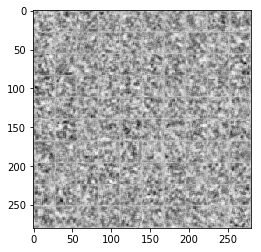

In [0]:
import matplotlib.pyplot as plt
a_img = adversary.img()
plt.imshow(a_img, cmap="Greys_r", interpolation="none")